# Technical Indicators

## 0. Imports & Basic formating

### a. Imports

In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
def import_data(path):
    data = pd.read_csv(path)
    df = data.copy()

    return df

def import_data_sent(path, columns):
    df = import_data(path)
    sentimental_data = df[columns]
    sent_df = sentimental_data.copy()

    return sent_df

### b. Basic Formating

In [3]:
def df_formating(df, columns):
    """
    Preprocess a DataFrame by renaming columns, setting columns to float64,
    dropping unnecessary columns, setting the 'date' column to datetime type,
    and setting the 'date' column as the index.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - columns (list): define which columns of df refere to which variable

    Returns:
    - pd.DataFrame: formated DataFrame.
    """
    # Step 1: Rename columns
    formated_df = df.rename(columns={
        columns[0]: 'date',
        columns[1]: 'open',
        columns[2]: 'high',
        columns[3]: 'low',
        columns[4]: 'adj_close',
        columns[5]: 'volume'
    })

    # Step 2: Set columns to float64
    formated_df = formated_df.astype({'open': 'float32', 'high': 'float32', 'low': 'float32', 'adj_close': 'float32', 'volume': 'float32'})

    # Step 3: Drop all other columns
    columns_to_keep = ['date', 'open', 'high', 'low', 'adj_close', 'volume']
    formated_df = formated_df[columns_to_keep]

    # Step 4: Set 'date' column to datetime type
    formated_df['date'] = pd.to_datetime(formated_df['date'], format='mixed')

    # Step 5: Set 'date' column as the index
    formated_df.set_index('date', inplace=True)

    return formated_df
    

In [4]:
def sent_df_formating(sent_df, columns_sent):
    """
    Preprocess a DataFrame by renaming columns, setting columns to float32,
    dropping unnecessary columns, setting the 'date' column to datetime type,
    and setting the 'date' column as the index.

    Parameters:
    - sent_df (pd.DataFrame): Input DataFrame.
    - columns_sent (list): define which columns of df refere to which price data

    Returns:
    - pd.DataFrame: formated DataFrame.
    """
    # Step 1: Rename columns
    sent_df = sent_df.rename(columns={
        columns_sent[0]: 'date',
        columns_sent[1]: 'score',
        columns_sent[2]: 'total',
        columns_sent[3]: 'positive',
        columns_sent[4]: 'negative'
    })

    # Step 2: Set columns to float64
    sent_df = sent_df.astype({'score': 'float32', 'total': 'float32', 'positive': 'float32', 'negative': 'float32'})

    # Step 3: Set 'date' column to datetime type
    sent_df['date'] = pd.to_datetime(sent_df['date'], format='mixed')

    # Step 4: Set 'date' column as the index
    sent_df.set_index('date', inplace=True)

    # Step 4: Drop Nan rows
    sent_formated_df = sent_df.dropna()
    
    return sent_formated_df

In [5]:
def price_df_formating(df, columns_price):
    """
    Preprocess a DataFrame by renaming columns, setting columns to float32,
    dropping unnecessary columns, setting the 'date' column to datetime type,
    and setting the 'date' column as the index.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - columns_price (list): define which columns of df refere to which variable

    Returns:
    - pd.DataFrame: formated DataFrame.
    """
    # Step 1: Rename columns
    formated_df = df.rename(columns={
        columns_price[0]: 'date',
        columns_price[1]: 'open',
        columns_price[2]: 'adj_close'
    })

    # Step 2: Set columns to float64
    formated_df = formated_df.astype({'open': 'float32', 'adj_close': 'float32'})

    # Step 3: Drop all other columns
    columns_to_keep = ['date', 'open', 'adj_close']
    formated_df = formated_df[columns_to_keep]

    # Step 4: Set 'date' column to datetime type
    formated_df['date'] = pd.to_datetime(formated_df['date'], format='mixed')

    # Step 5: Set 'date' column as the index
    formated_df.set_index('date', inplace=True)

    # Step 6: Drop Nan rows
    price_formated_df = formated_df.dropna()

    return price_formated_df

In [6]:
def labeling_df(formated_df):
    """
    Label a DataFrame by creating a new column 'label', set all values to 0 in that column, 
    set the values to 1 if open price is lower than adjusted close.

    Parameters:
    - formated_df (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: labeled DataFrame.
    """
    # Step 1: Create a new column 'Label' and initialize with 0 (down)
    formated_df['label'] = 0

    # Step 2: Label +1 (up) where 'Open' is lower than 'Adj Close'
    formated_df.loc[formated_df['open'] < formated_df['adj_close'], 'label'] = 1

    # Step 4: Rename df
    labeled_df = formated_df

    return labeled_df

In [7]:
def merge_df(labeled_df, sent_formated_df):
    """
    Merge two DataFrame with the inner merge method to keep a df of values for the matching indexes.

    Parameters:
    - labeled_df (pd.DataFrame): Input DataFrame.
    - sent_formated_df (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: merged DataFrame.
    """
    # Merge two df on their indexes
    merged_df = pd.merge(labeled_df, sent_formated_df, left_index=True, right_index=True)
    
    return merged_df

### c. Pipeline

In [8]:
path = "cleaned_merged_data-sample-with-sentiment-v02.csv"
columns = ['Datetime', 'Open-TSLA', 'High-TSLA', 'Low-TSLA', 'Adj Close-TSLA', 'Volume-TSLA']
columns_price = ['Datetime','Open-TSLA', 'Adj Close-TSLA']
columns_sent = ['Datetime', 'score_int', 'total_tweets', 'share_of_positive', 'share_of_negative']

In [9]:
def price_basic_formating(path, columns_price):
    df = import_data(path)
    
    price_formated_df = price_df_formating(df, columns_price)
    price_labeled_df = labeling_df(price_formated_df)

    return price_labeled_df

In [10]:
def features_basic_formating(path, columns):
    df = import_data(path)
    
    formated_df = df_formating(df, columns)
    labeled_df = labeling_df(formated_df)

    return labeled_df

In [11]:
def sent_and_features_basic_formating(path, columns_sent, columns):
    df = import_data(path)
    sent_df = import_data_sent(path, columns_sent)

    formated_df = df_formating(df, columns)
    labeled_df = labeling_df(formated_df)
    sent_formated_df = sent_df_formating(sent_df, columns_sent)
    merged_df = merge_df(labeled_df, sent_formated_df)

    return merged_df

## 1. Feature Engineering

### A. Moving Average (MA(5) & MA(20))

In [12]:
def moving_averages(df, column_name='adj_close', window_sizes=[5, 20]):
    """
    Add Moving Averages (MA) columns to the DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which moving averages are calculated.
    - window_sizes (list): List of window sizes for moving averages. Default is [5, 20].

    Returns:
    - pd.DataFrame: DataFrame with added MA columns.
    """
    for window_size in window_sizes:
        ma_column_name = f'MA_{window_size}'
        df[ma_column_name] = df[column_name].rolling(window=window_size).mean()

    return df

### B. Bollinger Band (BB up & BB down)

In [13]:
def bollinger_bands(df, column_name='adj_close', window_size=20, num_std_dev=2):
    """
    Calculate Bollinger Bands for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which Bollinger Bands are calculated.
    - window_size (int): Window size for the moving average. Default is 20.
    - num_std_dev (int): Number of standard deviations for the upper and lower bands. Default is 2.

    Returns:
    - pd.DataFrame: DataFrame with added columns for Bollinger Bands (BB up, BB down).
    """
    # Calculate the rolling mean (middle band)
    df['middle_band'] = df[column_name].rolling(window=window_size).mean()

    # Calculate the rolling standard deviation
    df['std_dev'] = df[column_name].rolling(window=window_size).std()

    # Calculate Bollinger Bands
    df['bb_up'] = df['middle_band'] + num_std_dev * df['std_dev']
    df['bb_down'] = df['middle_band'] - num_std_dev * df['std_dev']

    # Drop intermediate columns
    df.drop(['middle_band', 'std_dev'], axis=1, inplace=True)

    return df

### C. Relative Difference in the Percentage of the price (RDP(1))

In [14]:
def rdp(df, column_name='adj_close'):
    """
    Calculate Relative Difference in the Percentage of the price (RDP(1)) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which RDP(1) is calculated.

    Returns:
    - pd.DataFrame: DataFrame with an added column for RDP(1).
    """
    # Calculate RDP(1)
    df['rdp_1'] = df[column_name].pct_change() * 100

    return df

### D. Bias Ratio (BIAS(6), BIAS(12) & BIAS(24))

In [15]:
def bias(df, column_name='adj_close', ma_windows=[6, 12, 24]):
    """
    Calculate Bias Ratios (BIAS) for specified moving average windows for a column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which BIAS is calculated.
    - ma_windows (list): List of moving average window sizes. Default is [6, 12, 24].

    Returns:
    - pd.DataFrame: DataFrame with added columns for BIAS(6), BIAS(12), and BIAS(24).
    """
    for window_size in ma_windows:
        ma_column_name = f'MA_{window_size}'
        bias_column_name = f'BIAS_{window_size}'

        # Calculate the moving average
        df[ma_column_name] = df[column_name].rolling(window=window_size).mean()

        # Calculate BIAS
        df[bias_column_name] = ((df[column_name] - df[ma_column_name]) / df[ma_column_name]) * 100

        # Drop intermediate columns
        df.drop(ma_column_name, axis=1, inplace=True)

    return df

### E. Relative Strength Index (RSI)

In [16]:
def rsi(df, column_name='adj_close', window=14):
    """
    Calculate the Relative Strength Index (RSI) for a specified column in a DataFrame.

    Parameters:
    - df: (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which RSI is calculated. Default is 'Close'.
    - window (int): Window size for RSI calculation. Default is 14.

    Returns:
    - pd.DataFrame: DataFrame with an added column for RSI.
    """
    # Calculate daily price changes
    df['price_change'] = df[column_name].diff()

    # Calculate the average gain and average loss over the specified window
    df['gain'] = df['price_change'].apply(lambda x: x if x > 0 else 0).rolling(window=window, min_periods=1).mean()
    df['loss'] = -df['price_change'].apply(lambda x: x if x < 0 else 0).rolling(window=window, min_periods=1).mean()

    # Calculate relative strength (RS)
    df['rs'] = df['gain'] / df['loss']

    # Calculate RSI
    df['rsi'] = 100 - (100 / (1 + df['rs']))

    # Drop intermediate columns
    df.drop(['price_change', 'gain', 'loss', 'rs'], axis=1, inplace=True)

    return df

### F. Exponential Moving Average (EMA(12) & EMA(26))

In [17]:
def ema(df, column_name='adj_close', ema_short=12, ema_long=26):
    """
    Calculate Exponential Moving Averages (EMA) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which EMA is calculated. Default is 'Close'.
    - ema_short (int): Short-term EMA window size. Default is 12.
    - ema_long (int): Long-term EMA window size. Default is 26.

    Returns:
    - pd.DataFrame: DataFrame with added columns for EMA(12) and EMA(26).
    """
    # Calculate EMA(12)
    df['ema_12'] = df[column_name].ewm(span=ema_short, adjust=False).mean()

    # Calculate EMA(26)
    df['ema_26'] = df[column_name].ewm(span=ema_long, adjust=False).mean()

    return df

### G. Moving Average Convergence/Divergence (MACD)

In [18]:
def macd(df, column_name='adj_close', ema_short=12, ema_long=26, signal_period=9):
    """
    Calculate Moving Average Convergence Divergence (MACD) and its signal line for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which MACD is calculated. Default is 'Close'.
    - ema_short (int): Short-term EMA window size. Default is 12.
    - ema_long (int): Long-term EMA window size. Default is 26.
    - signal_period (int): Signal line EMA window size. Default is 9.

    Returns:
    - pd.DataFrame: DataFrame with added columns for MACD, Signal Line, and MACD Histogram.
    """
    # Calculate short-term EMA
    df['ema_short'] = df[column_name].ewm(span=ema_short, adjust=False).mean()

    # Calculate long-term EMA
    df['ema_long'] = df[column_name].ewm(span=ema_long, adjust=False).mean()

    # Calculate MACD Line
    df['dif'] = df['ema_short'] - df['ema_long']

    # Calculate Signal Line
    df['signal_line'] = df['dif'].ewm(span=signal_period, adjust=False).mean()

    # Calculate MACD Histogram
    df['osc'] = df['dif'] - df['signal_line']

    # Drop intermediate columns
    df.drop(['ema_short', 'ema_long'], axis=1, inplace=True)

    return df

### H. Psychological Line (PSY(12) & PSY(24))

In [19]:
def psy(df, column_name='adj_close', psy_short=12, psy_long=24):
    """
    Calculate Psychological Line (PSY) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which PSY is calculated. Default is 'Close'.
    - psy_short (int): Short-term PSY window size. Default is 12.
    - psy_long (int): Long-term PSY window size. Default is 24.

    Returns:
    - pd.DataFrame: DataFrame with added columns for PSY(12) and PSY(24).
    """
    # Calculate the percentage of days where the closing price is higher than the previous day's closing price
    df['price_up'] = df[column_name].diff() > 0

    # Calculate PSY(12)
    df['psy_12'] = df['price_up'].rolling(window=psy_short).mean() * 100

    # Calculate PSY(24)
    df['psy_24'] = df['price_up'].rolling(window=psy_long).mean() * 100

    # Drop intermediate columns
    df.drop(['price_up'], axis=1, inplace=True)

    return df

### I. Williams %R (WMS%R)

In [20]:
def williams_percent_r(df, high_column='high', low_column='low', adj_close_column='adj_close', window=14):
    """
    Calculate Williams %R for a specified high, low, and close columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - high_column (str): Name of the column containing high prices. Default is 'High'.
    - low_column (str): Name of the column containing low prices. Default is 'Low'.
    - adj_close_column (str): Name of the column containing close prices. Default is 'Close'.
    - window (int): Window size for Williams %R calculation. Default is 14.

    Returns:
    - pd.DataFrame: DataFrame with an added column for Williams %R.
    """
    # Calculate highest high and lowest low over the specified window
    df['hh'] = df[high_column].rolling(window=window).max()
    df['ll'] = df[low_column].rolling(window=window).min()

    # Calculate Williams %R
    df['williams_%r'] = (df['hh'] - df[adj_close_column]) / (df['hh'] - df['ll']) * -100

    # Drop intermediate columns
    df.drop(['hh', 'll'], axis=1, inplace=True)

    return df

### J. Stochastic Oscillator (Stochastic%K & Stochastic%D)

In [21]:
def stochastic_oscillator(df, high_column='high', low_column='low', adj_close_column='adj_close', k_window=14, d_window=3):
    """
    Calculate Stochastic Oscillator (%K and %D) for specified high, low, and close columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - high_column (str): Name of the column containing high prices. Default is 'High'.
    - low_column (str): Name of the column containing low prices. Default is 'Low'.
    - close_column (str): Name of the column containing close prices. Default is 'Close'.
    - k_window (int): Window size for %K calculation. Default is 14.
    - d_window (int): Window size for %D calculation. Default is 3.

    Returns:
    - pd.DataFrame: DataFrame with added columns for Stochastic %K and %D.
    """
    # Calculate lowest low and highest high over the specified window
    df['ll'] = df[low_column].rolling(window=k_window).min()
    df['hh'] = df[high_column].rolling(window=k_window).max()

    # Calculate Stochastic %K
    df['stochastic_%k'] = ((df[adj_close_column] - df['ll']) / (df['hh'] - df['ll'])) * 100

    # Calculate Stochastic %D (3-day simple moving average of %K)
    df['stochastic_%d'] = df['stochastic_%k'].rolling(window=d_window).mean()

    # Drop intermediate columns
    df.drop(['ll', 'hh'], axis=1, inplace=True)

    return df

### K. Percentage of Price Change (PROC)

In [22]:
def proc(df, column_name='adj_close', window=1):
    """
    Calculate Percentage of Price Change (PROC) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which PROC is calculated. Default is 'Close'.
    - window (int): Window size for PROC calculation. Default is 1.

    Returns:
    - pd.DataFrame: DataFrame with an added column for PROC.
    """
    # Calculate the percentage change in price using rolling window
    df['proc'] = df[column_name].pct_change().rolling(window=window).mean() * 100

    return df

### L. Momentum (MO(1))

In [23]:
def momentum(df, column_name='adj_close', window=1):
    """
    Calculate Momentum (MO) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which Momentum is calculated. Default is 'Close'.
    - window (int): Window size for Momentum calculation. Default is 1.

    Returns:
    - pd.DataFrame: DataFrame with an added column for Momentum.
    """
    # Calculate the difference in price over the specified window
    df['momentum'] = df[column_name].diff(window)

    return df

### M. First-Order Lag (LAG(1))

In [24]:
def first_order_lag(df, column_name='adj_close', lag=1):
    """
    Calculate First-Order Lag (LAG(1)) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which the lag is calculated. Default is 'Close'.
    - lag (int): Number of periods to lag. Default is 1.

    Returns:
    - pd.DataFrame: DataFrame with an added column for the First-Order Lag.
    """
    # Calculate the First-Order Lag using the shift() method
    df[f'LAG_{lag}'] = df[column_name].shift(lag)

    return df

### N. Trading Volume (VOL)

In [25]:
def trading_volume(df, volume_column='volume'):
    """
    Calculate Trading Volume (VOL) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - volume_column (str): Name of the column containing trading volume. Default is 'Volume'.

    Returns:
    - pd.DataFrame: DataFrame with an added column for Trading Volume.
    """
    df['vol'] = df[volume_column]

    return df

### O. Pipeline

In [26]:
def feature_engineering(df):

    moving_averages(df)
    bollinger_bands(df)
    rdp(df)
    bias(df)
    rsi(df)
    ema(df)
    macd(df)
    psy(df)
    williams_percent_r(df)
    stochastic_oscillator(df)
    proc(df)
    momentum(df)
    first_order_lag(df)
    trading_volume(df)
    
    return df

## 2. Preprocessing

### a. Removing columns and rows

In [27]:
def drop_columns(df, columns_to_drop=['open', 'high', 'low', 'adj_close', 'volume']):
    """
    Drop specified columns from a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - columns_to_drop (list): List of column names to drop. Default is ['Open', 'High', 'Low', 'Adj_Close', 'Volume'].

    Returns:
    - pd.DataFrame: DataFrame with specified columns dropped.
    """
    # Drop specified columns
    df = df.drop(columns=columns_to_drop, errors='ignore')

    return df

In [28]:
def drop_rows(df):
    """
    Drop all rows with NaN values from a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: DataFrame with NaN rows dropped.
    """
    # Drop rows with NaN values
    cleaned_df = df.dropna()

    return cleaned_df

### b. Scaling

In [29]:
def scale_dataframe(df):
    """
    Scale a DataFrame using Standard scaling.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: Scaled DataFrame.
    """
    # Scale the selected columns
    scaler = StandardScaler()

    index_column = df.index
    
    label_column = df['label']
    int_df = df.drop(columns=['label'])
    
    columns_to_scale = int_df.columns
    
    scaled_df = pd.DataFrame(scaler.fit_transform(int_df), columns=columns_to_scale)
    scaled_df.index = index_column
    scaled_df['label'] = label_column
    
    return scaled_df

### c. Train Test Split

In [30]:
def train_test_split(df, test_size=0.2):
    """
    Split a time series dataset into training and testing sets.

    Parameters:
    - df: the input time series dataset.
    - test_size (float): the proportion of the dataset to include in the test split.

    Returns:
    - df_train, df_test: Pandas arrays, representing features and target values for each set.
    """
    
    # Extract index number of splitting points
    len_df = len(df)
    index_1 = round(len_df*(1-(test_size)))
    index_2 = index_1 +1

    # Extract values at previously calculated splitting points
    date_1 = df.index[index_1]
    date_2 = df.index[index_2]

    # Construct train_df, val_df and test_df
    df_train = df[:date_1]
    df_test = df[date_2:]
    
    return df_train, df_test

### d. Reshape Matrix

In [31]:
def input_matrix_split_X_y(df, window_size=5):
    """
    Reshape a DataFrames into two 3D NumPy arrays 

    Parameters:
    - df: DataFrame with a list of time series data
    - window_size: the number of time steps to consider for each observation

    Returns:
    - X: (num_observations, window_size, num_features)
    - y: (num_observations, num_features_to_predict)
    """
    df_np = df.to_numpy()
    X = []
    y = []
    
    df_X = df.drop('label', axis=1)
    df_y = df['label']

    for i in range(len(df_np)-(window_size)):
        row = df_X[i:i+window_size]
        X.append(row)
        label = df_y[i+(window_size)]
        y.append(label)

    X = np.array(X)
    y = np.array(y)
    y = np.expand_dims(y, axis=-1)
    
    return X, y

### e. Pipeline

In [32]:
columns_to_drop = ['open']

In [33]:
def preprocessing(df):
    
    clean_merged_df = drop_columns(df)
    clean_merged_df = drop_rows(clean_merged_df)
    scaled_clean_merged_df = scale_dataframe(clean_merged_df)
    split_scaled_clean_merged_df = train_test_split(scaled_clean_merged_df)
    X_train, y_train = input_matrix_split_X_y(split_scaled_clean_merged_df[0])
    X_test, y_test = input_matrix_split_X_y(split_scaled_clean_merged_df[1])

    return X_train, y_train, X_test, y_test

In [34]:
def preprocessing_price(df, columns_to_drop):
    
    clean_merged_df = drop_columns(df, columns_to_drop)
    clean_merged_df = drop_rows(clean_merged_df)
    scaled_clean_merged_df = scale_dataframe(clean_merged_df)
    split_scaled_clean_merged_df = train_test_split(scaled_clean_merged_df)
    X_train, y_train = input_matrix_split_X_y(split_scaled_clean_merged_df[0])
    X_test, y_test = input_matrix_split_X_y(split_scaled_clean_merged_df[1])

    return X_train, y_train, X_test, y_test

## 3. Models

### a. Baseline Model

In [52]:
def baseline_model_initialization(X_train, window_size=5, loss_function='binary_crossentropy', optimizer_name='adam', metrics_list=['accuracy']):
    
    #############################
    #  1 - Model architecture   #
    ############################# 
    
    model = models.Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(window_size, X_train.shape[-1])))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    
    #############################
    #  2 - Optimization Method  #
    #############################
    model.compile(loss= loss_function,
                  optimizer = optimizer_name, 
                  metrics = metrics_list) 

    return model

In [36]:
def baseline_model_training(model, X_train, y_train, patience=5, validation_split=0.2, batch_size=64, epochs=100, verbose=0):

    es = EarlyStopping(patience=patience, restore_best_weights=True)
    
    history = model.fit(X_train, y_train,
                        validation_split=validation_split,
                        batch_size=batch_size,
                        epochs=epochs, 
                        callbacks=[es],
                        verbose=verbose)

    return history

In [37]:
def baseline_model_validation(model, X_test, y_test, verbose=0):

    model_acc = model.evaluate(X_test, y_test, verbose=verbose)

    return model_acc

In [38]:
def baseline_model_prediction(model, X_test, threshold = 0.5):

    y_pred = model.predict(X_test).flatten()
    binary_predictions = (y_pred >= threshold).astype(int)

    return binary_predictions

### b. LSTM Model

In [39]:
def lstm_model_initialization(X_train, window_size=5, loss_function='binary_crossentropy', optimizer_name='adam', metrics_list=['accuracy']):
    
    #############################
    #  1 - Model architecture   #
    ############################# 
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    model = Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(units=20, activation='tanh', return_sequences=True, input_shape=(window_size, X_train.shape[-1])))
    model.add(layers.LSTM(units=20, activation='tanh', return_sequences=False))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    #############################
    #  2 - Optimization Method  #
    #############################
    model.compile(loss= loss_function,
                  optimizer = optimizer_name, 
                  metrics = metrics_list) 

    return model

In [40]:
def lstm_model_training(model, X_train, y_train, patience=5, validation_split=0.2, batch_size=64, epochs=100, verbose=0):

    es = EarlyStopping(patience=patience, restore_best_weights=True)
    
    history = model.fit(X_train, y_train,
                        validation_split=validation_split,
                        batch_size=batch_size,
                        epochs=epochs, 
                        callbacks=[es],
                        verbose=verbose)

    return history

In [41]:
def lstm_model_validation(model, X_test, y_test, verbose=0):

    model_acc = model.evaluate(X_test, y_test, verbose=verbose)

    return model_acc

In [42]:
def lstm_model_prediction(model, X_test, threshold = 0.5):

    y_pred = model.predict(X_test).flatten()
    binary_predictions = (y_pred >= threshold).astype(int)

    return binary_predictions

### c. GRU Model

In [43]:
def gru_model_initialization(X_train, window_size=5, loss_function='binary_crossentropy', optimizer_name='adam', metrics_list=['accuracy']):
    
    #############################
    #  1 - Model architecture   #
    ############################# 
    model = Sequential()
    model.add(layers.Masking(mask_value=-1., input_shape=(window_size, X_train.shape[-1])))
    model.add(layers.GRU(units=20, activation='tanh', return_sequences=True))
    model.add(layers.GRU(units=20, activation='tanh', return_sequences=False))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    #############################
    #  2 - Optimization Method  #
    #############################
    model.compile(loss= loss_function,
                  optimizer = optimizer_name, 
                  metrics = metrics_list) 

    return model

In [44]:
def gru_model_training(model, X_train, y_train, patience=5, validation_split=0.2, batch_size=64, epochs=100, verbose=0):

    es = EarlyStopping(patience=patience, restore_best_weights=True)
    
    history = model.fit(X_train, y_train,
                        validation_split=validation_split,
                        batch_size=batch_size,
                        epochs=epochs, 
                        callbacks=[es],
                        verbose=verbose)

    return history

In [45]:
def gru_model_validation(model, X_test, y_test, verbose=0):

    model_acc = model.evaluate(X_test, y_test, verbose=verbose)

    return model_acc

In [46]:
def gru_model_prediction(model, X_test, threshold = 0.5):

    y_pred = model.predict(X_test).flatten()
    binary_predictions = (y_pred >= threshold).astype(int)

    return binary_predictions

## 4. Compare Models

### a. Baseline Model

In [53]:
price_labeled_df = price_basic_formating(path, columns_price)
b_X_train, b_y_train, b_X_test, b_y_test = preprocessing_price(price_labeled_df, columns_to_drop)

b_model = baseline_model_initialization(b_X_train)
b_history = baseline_model_training(b_model, b_X_train, b_y_train)
b_model_acc = baseline_model_validation(b_model, b_X_test, b_y_test)
b_y_pred = baseline_model_prediction(b_model, b_X_test)

/var/folders/l4/q_79lrcx3ps_z7hltvr9nl4c0000gn/T/ipykernel_7239/3659344757.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = df_y[i+(window_size)]
/var/folders/l4/q_79lrcx3ps_z7hltvr9nl4c0000gn/T/ipykernel_7239/3659344757.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = df_y[i+(window_size)]


8/8 [==============================] - 0s 832us/step


### b. LSTM Model

In [50]:
labeled_df = features_basic_formating(path, columns)
feature_labeled_df = feature_engineering(labeled_df)
f_X_train, f_y_train, f_X_test, f_y_test = preprocessing(feature_labeled_df)

f_lstm_model = lstm_model_initialization(f_X_train)
f_lstm_history = lstm_model_training(f_lstm_model, f_X_train, f_y_train)
f_lstm_model_acc = lstm_model_validation(f_lstm_model, f_X_test, f_y_test)
f_lstm_y_pred = lstm_model_prediction(f_lstm_model, f_X_test)

f_gru_model = gru_model_initialization(f_X_train)
f_gru_history = gru_model_training(f_gru_model, f_X_train, f_y_train)
f_gru_model_acc = gru_model_validation(f_gru_model, f_X_test, f_y_test)
f_gru_y_pred = gru_model_prediction(f_gru_model, f_X_test)

/var/folders/l4/q_79lrcx3ps_z7hltvr9nl4c0000gn/T/ipykernel_7239/3659344757.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = df_y[i+(window_size)]
/var/folders/l4/q_79lrcx3ps_z7hltvr9nl4c0000gn/T/ipykernel_7239/3659344757.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = df_y[i+(window_size)]


8/8 [==============================] - 1s 1ms/step


### c. GRU Model

In [51]:
merged_df = sent_and_features_basic_formating(path, columns_sent, columns)
sent_feature_labeled_df = feature_engineering(merged_df)
sf_X_train, sf_y_train, sf_X_test, sf_y_test = preprocessing(sent_feature_labeled_df)

sf_lstm_model = lstm_model_initialization(sf_X_train)
sf_lstm_history = lstm_model_training(sf_lstm_model, sf_X_train, sf_y_train)
sf_lstm_model_acc = lstm_model_validation(sf_lstm_model, sf_X_test, sf_y_test)
sf_lstm_y_pred = lstm_model_prediction(sf_lstm_model, sf_X_test)

sf_gru_model = gru_model_initialization(sf_X_train)
sf_gru_history = gru_model_training(sf_gru_model, sf_X_train, sf_y_train)
sf_gru_model_acc = gru_model_validation(sf_gru_model, sf_X_test, sf_y_test)
sf_gru_y_pred = gru_model_prediction(sf_gru_model, sf_X_test)

/var/folders/l4/q_79lrcx3ps_z7hltvr9nl4c0000gn/T/ipykernel_7239/3659344757.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = df_y[i+(window_size)]
/var/folders/l4/q_79lrcx3ps_z7hltvr9nl4c0000gn/T/ipykernel_7239/3659344757.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = df_y[i+(window_size)]


8/8 [==============================] - 1s 1ms/step


### d. Compare Models

In [172]:
def plot_dataframe(real_values, predicted_values, title="Real vs Predicted", xlabel="Index", ylabel="Values"):

    pred_df = pd.DataFrame({'Real Values': real_values.flatten(), 'Predicted Values': predicted_values})
    
    plt.figure(figsize=(10, 6))
    plt.plot(pred_df.index, pred_df['Real Values'], label='Real Values')
    plt.plot(pred_df.index, pred_df['Predicted Values'], label='Predicted Values')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()


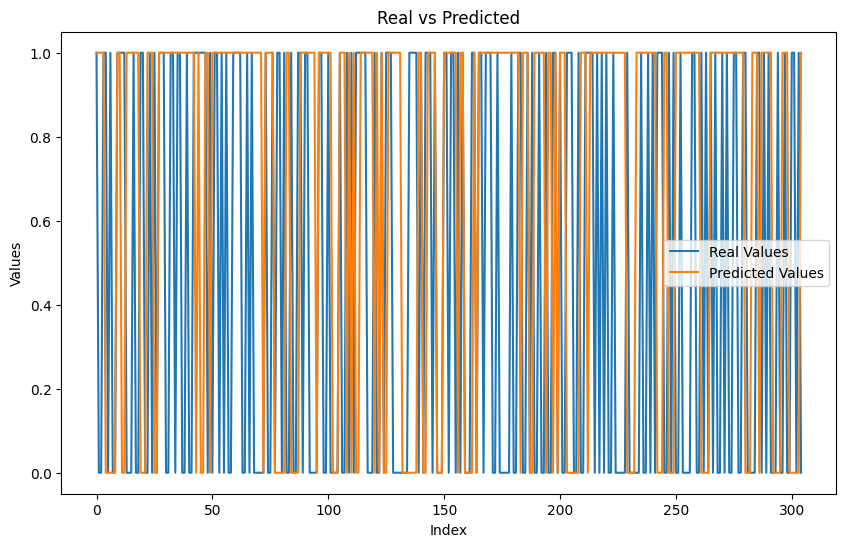

In [173]:
plot_dataframe(sf_y_test, sf_gru_y_pred)

In [174]:
def compare_models_graph(model, history, model_acc):
    # Plotting
    plt.figure(figsize=(12, 6))

    # Accuracy Plots
    plt.subplot(1, 2, 1)
    plt.bar(1, history.history['accuracy'], label='Train', alpha=0.7)
    plt.bar(2, history.history['val_accuracy'], label='Validation', alpha=0.7)
    plt.bar(3, model_acc[1], label='Test', alpha=0.7)
    plt.title('Accuracy Comparison')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plots
    plt.subplot(1, 2, 2)
    plt.bar(1, history.history['loss'], label='Train', alpha=0.7)
    plt.bar(2, history.history['val_loss'], label='Validation', alpha=0.7)
    plt.bar(3, model_acc[0], label='Test', alpha=0.7)
    plt.title('Loss Comparison')
    plt.xlabel('Models')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

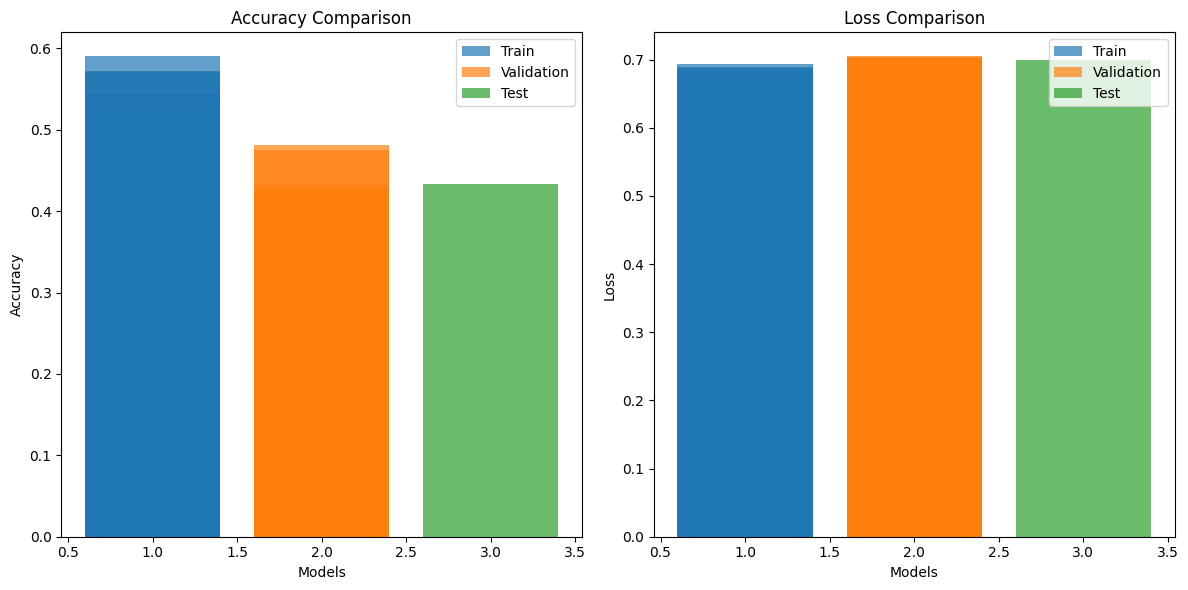

In [175]:
compare_models_graph(sf_gru_model, sf_gru_history, sf_gru_model_acc)

## 6. Model Optimisation template idea

### a. LSTM

In [54]:
%time

# Model hyperparameters
num_layers = [1, 2, 3] # 2, 2, 2, 2
layer_sizes = [50, 60, 70, 80] # 50, 60, 80, 70
batch_sizes = [64, 128] # 128, 64, 64, 128
learning_rates = [0.1, 1.0, 2.0] # 0.1, 1, 2, 0.1
epochs = [50, 60, 70, 80] # 50, 60, 50, 80
activ_func = 'relu'

best_model = None
best_performance = 0.0
best_weights = 0.0
best_hyperparameters = {}
count = 0

# Iterate over hyperparameter combinations
for num_layer in num_layers:
    for layer_size in layer_sizes:
        for batch_size in batch_sizes:
            for learning_rate in learning_rates:
                for epoch in epochs:
                    count += 1
                    # Build the LSTM model
                    model = Sequential()
                    
                    # Add the specified number of LSTM layers
                    for _ in range(num_layer):
                        model.add(LSTM(layer_size, activation=activ_func, input_shape=(5, X_train.shape[-1]), return_sequences=True))
                    
                    # Flatten if there are multiple LSTM layers
                    if num_layer > 1:
                        model.add(Flatten())
                    
                    # Output layer
                    model.add(Dense(1, activation='sigmoid'))
                    
                    # Compile the model
                    optimizer = Adam(learning_rate=learning_rate)
                    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
                    
                    # Print model summary
                    print(model.summary())
                    
                    # Train the model
                    es = EarlyStopping(patience=5, restore_best_weights=True)
                    history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_split=0.2, callbacks=[es], verbose=2)
                    
                    val_performance = history.history['val_accuracy'][-1]
                    
                    # Check if this configuration is the best so far
                    if val_performance > best_performance:
                        best_performance = val_performance
                        best_model = model
                        best_hyperparameters = {
                            'num_layer': num_layer,
                            'layer_size': layer_size,
                            'batch_size': batch_size,
                            'learning_rate': learning_rate,
                            'epochs': epoch
                        }

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.11 µs
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_2 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 1.0806 - accuracy: 0.5213 - val_loss: 0.7726 - val_accuracy: 0.5192 - 541ms/epoch - 42ms/step
Epoch 2/50
13/13 - 0s - loss: 0.7574 - accuracy: 0.5038 - val_loss: 0.8236 - val_accuracy: 0.4727 - 37ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 0.7194 - accuracy: 0.5574 - val_loss: 0.8042 - val_accuracy: 0.4646 -

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_3 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 1.1214 - accuracy: 0.4985 - val_loss: 0.8895 - val_accuracy: 0.5152 - 564ms/epoch - 43ms/step
Epoch 2/60
13/13 - 0s - loss: 0.7442 - accuracy: 0.5178 - val_loss: 1.0395 - val_accuracy: 0.4768 - 35ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 0.7109 - accuracy: 0.5467 - val_loss: 0.8592 - val_accuracy: 0.4919 - 34ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 0.6868 - ac

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_4 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 1.1236 - accuracy: 0.4929 - val_loss: 0.7779 - val_accuracy: 0.4970 - 549ms/epoch - 42ms/step
Epoch 2/70
13/13 - 0s - loss: 0.7476 - accuracy: 0.5259 - val_loss: 1.0313 - val_accuracy: 0.4747 - 36ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 0.7107 - accuracy: 0.5297 - val_loss: 0.7116 - val_accuracy: 0.4970 - 35ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 0.6905 - ac

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_5 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 1.1461 - accuracy: 0.5173 - val_loss: 0.7727 - val_accuracy: 0.4616 - 644ms/epoch - 50ms/step
Epoch 2/80
13/13 - 0s - loss: 0.7217 - accuracy: 0.5183 - val_loss: 0.7462 - val_accuracy: 0.5091 - 36ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 0.7009 - accuracy: 0.5287 - val_loss: 0.7590 - val_accuracy: 0.4758 - 36ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 0.6815 - ac

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_6 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 7.1872 - accuracy: 0.4934 - val_loss: 7.9262 - val_accuracy: 0.4838 - 537ms/epoch - 41ms/step
Epoch 2/50
13/13 - 0s - loss: 7.4225 - accuracy: 0.5147 - val_loss: 7.7022 - val_accuracy: 0.4970 - 35ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 7.6468 - accuracy: 0.4992 - val_loss: 7.7363 - val_accuracy: 0.4939 - 37ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 7.2459 - ac

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_7 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 7.5621 - accuracy: 0.4650 - val_loss: 7.1625 - val_accuracy: 0.5303 - 530ms/epoch - 41ms/step
Epoch 2/60
13/13 - 0s - loss: 8.1045 - accuracy: 0.4685 - val_loss: 7.1625 - val_accuracy: 0.5303 - 35ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 8.1045 - accuracy: 0.4685 - val_loss: 7.1625 - val_accuracy: 0.5303 - 35ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 8.1045 - ac

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_8 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 6.7955 - accuracy: 0.5132 - val_loss: 8.1799 - val_accuracy: 0.4697 - 528ms/epoch - 41ms/step
Epoch 2/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 33ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 34ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 7.2231 - ac

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_9 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 7.1833 - accuracy: 0.5005 - val_loss: 7.7023 - val_accuracy: 0.4980 - 535ms/epoch - 41ms/step
Epoch 2/80
13/13 - 0s - loss: 7.5901 - accuracy: 0.5061 - val_loss: 7.8797 - val_accuracy: 0.4869 - 33ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 7.3651 - accuracy: 0.5213 - val_loss: 8.0078 - val_accuracy: 0.4798 - 35ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 7.2966 - a

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_10 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 7.4669 - accuracy: 0.4784 - val_loss: 7.1625 - val_accuracy: 0.5303 - 535ms/epoch - 41ms/step
Epoch 2/50
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 35ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 35ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 8.1084 - a

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_11 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 7.4662 - accuracy: 0.4731 - val_loss: 7.1957 - val_accuracy: 0.5283 - 531ms/epoch - 41ms/step
Epoch 2/60
13/13 - 0s - loss: 8.0816 - accuracy: 0.4701 - val_loss: 7.2107 - val_accuracy: 0.5273 - 35ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 8.0816 - accuracy: 0.4701 - val_loss: 7.2263 - val_accuracy: 0.5263 - 34ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 8.0420 - a

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_12 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 7.5691 - accuracy: 0.4657 - val_loss: 7.1625 - val_accuracy: 0.5303 - 686ms/epoch - 53ms/step
Epoch 2/70
13/13 - 0s - loss: 8.1162 - accuracy: 0.4678 - val_loss: 7.1625 - val_accuracy: 0.5303 - 34ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 8.1162 - accuracy: 0.4678 - val_loss: 7.1625 - val_accuracy: 0.5303 - 36ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 8.1162 - a

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_13 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 6.7474 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 533ms/epoch - 41ms/step
Epoch 2/80
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 36ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 35ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 7.2231 - a

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_14 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 1.4287 - accuracy: 0.4698 - val_loss: 0.8409 - val_accuracy: 0.5020 - 523ms/epoch - 75ms/step
Epoch 2/50
7/7 - 0s - loss: 0.7636 - accuracy: 0.5310 - val_loss: 0.9648 - val_accuracy: 0.4636 - 27ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 0.7229 - accuracy: 0.5404 - val_loss: 0.8390 - val_accuracy: 0.4798 - 28ms/epoch - 4ms/step
Epoch 4/50
7/7 - 0s - loss: 0.7051 - accuracy:

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_15 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 1.7083 - accuracy: 0.4901 - val_loss: 1.0909 - val_accuracy: 0.4788 - 520ms/epoch - 74ms/step
Epoch 2/60
7/7 - 0s - loss: 0.7785 - accuracy: 0.5183 - val_loss: 0.8263 - val_accuracy: 0.4636 - 28ms/epoch - 4ms/step
Epoch 3/60
7/7 - 0s - loss: 0.7227 - accuracy: 0.5373 - val_loss: 0.8953 - val_accuracy: 0.4768 - 27ms/epoch - 4ms/step
Epoch 4/60
7/7 - 0s - loss: 0.7178 - accuracy:

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_16 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 1.5310 - accuracy: 0.4952 - val_loss: 1.0617 - val_accuracy: 0.5283 - 521ms/epoch - 74ms/step
Epoch 2/70
7/7 - 0s - loss: 0.8074 - accuracy: 0.5063 - val_loss: 0.9667 - val_accuracy: 0.4636 - 26ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 0.7351 - accuracy: 0.5335 - val_loss: 0.7724 - val_accuracy: 0.5040 - 28ms/epoch - 4ms/step
Epoch 4/70
7/7 - 0s - loss: 0.6970 - accuracy:

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_17 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 1.7640 - accuracy: 0.5071 - val_loss: 0.7180 - val_accuracy: 0.4889 - 525ms/epoch - 75ms/step
Epoch 2/80
7/7 - 0s - loss: 0.7241 - accuracy: 0.5426 - val_loss: 0.7973 - val_accuracy: 0.4909 - 28ms/epoch - 4ms/step
Epoch 3/80
7/7 - 0s - loss: 0.7261 - accuracy: 0.5320 - val_loss: 0.8286 - val_accuracy: 0.4929 - 28ms/epoch - 4ms/step
Epoch 4/80
7/7 - 0s - loss: 0.6922 - accuracy:

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_18 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 6.0370 - accuracy: 0.5254 - val_loss: 7.8916 - val_accuracy: 0.4848 - 531ms/epoch - 76ms/step
Epoch 2/50
7/7 - 0s - loss: 7.2469 - accuracy: 0.5294 - val_loss: 8.0330 - val_accuracy: 0.4778 - 29ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 7.2588 - accuracy: 0.5292 - val_loss: 7.9506 - val_accuracy: 0.4838 - 28ms/epoch - 4ms/step
Epoch 4/50
7/7 - 0s - loss: 7.2398 - accuracy:

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_19 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 6.1626 - accuracy: 0.5190 - val_loss: 8.0934 - val_accuracy: 0.4747 - 524ms/epoch - 75ms/step
Epoch 2/60
7/7 - 0s - loss: 7.1906 - accuracy: 0.5338 - val_loss: 8.1625 - val_accuracy: 0.4697 - 27ms/epoch - 4ms/step
Epoch 3/60
7/7 - 0s - loss: 7.1829 - accuracy: 0.5340 - val_loss: 8.0813 - val_accuracy: 0.4758 - 28ms/epoch - 4ms/step
Epoch 4/60
7/7 - 0s - loss: 7.2223 - accuracy:

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_20 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 7.0452 - accuracy: 0.4607 - val_loss: 7.1625 - val_accuracy: 0.5303 - 690ms/epoch - 99ms/step
Epoch 2/70
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 28ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 27ms/epoch - 4ms/step
Epoch 4/70
7/7 - 0s - loss: 8.1084 - accuracy:

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_21 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 6.0868 - accuracy: 0.5277 - val_loss: 8.1799 - val_accuracy: 0.4697 - 526ms/epoch - 75ms/step
Epoch 2/80
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 27ms/epoch - 4ms/step
Epoch 3/80
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 28ms/epoch - 4ms/step
Epoch 4/80
7/7 - 0s - loss: 7.2231 - accuracy:

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_22 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 6.2743 - accuracy: 0.5061 - val_loss: 8.2440 - val_accuracy: 0.4646 - 522ms/epoch - 75ms/step
Epoch 2/50
7/7 - 0s - loss: 7.3103 - accuracy: 0.5256 - val_loss: 8.2192 - val_accuracy: 0.4667 - 28ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 7.3526 - accuracy: 0.5228 - val_loss: 8.1875 - val_accuracy: 0.4687 - 28ms/epoch - 4ms/step
Epoch 4/50
7/7 - 0s - loss: 7.3639 - accuracy:

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_23 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 7.1184 - accuracy: 0.4480 - val_loss: 7.1625 - val_accuracy: 0.5303 - 555ms/epoch - 79ms/step
Epoch 2/60
7/7 - 0s - loss: 8.1472 - accuracy: 0.4657 - val_loss: 7.1625 - val_accuracy: 0.5303 - 28ms/epoch - 4ms/step
Epoch 3/60
7/7 - 0s - loss: 8.0010 - accuracy: 0.4756 - val_loss: 7.1625 - val_accuracy: 0.5303 - 28ms/epoch - 4ms/step
Epoch 4/60
7/7 - 0s - loss: 8.0102 - accuracy:

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_24 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 6.6602 - accuracy: 0.4952 - val_loss: 7.2266 - val_accuracy: 0.5263 - 527ms/epoch - 75ms/step
Epoch 2/70
7/7 - 0s - loss: 7.1953 - accuracy: 0.5294 - val_loss: 7.1960 - val_accuracy: 0.5283 - 28ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 7.2558 - accuracy: 0.5261 - val_loss: 7.2337 - val_accuracy: 0.5263 - 29ms/epoch - 4ms/step
Epoch 4/70
7/7 - 0s - loss: 7.2810 - accuracy:

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_25 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 6.3723 - accuracy: 0.5297 - val_loss: 8.1792 - val_accuracy: 0.4697 - 556ms/epoch - 79ms/step
Epoch 2/80
7/7 - 0s - loss: 7.2754 - accuracy: 0.5279 - val_loss: 8.2254 - val_accuracy: 0.4667 - 28ms/epoch - 4ms/step
Epoch 3/80
7/7 - 0s - loss: 7.2678 - accuracy: 0.5284 - val_loss: 8.1631 - val_accuracy: 0.4707 - 28ms/epoch - 4ms/step
Epoch 4/80
7/7 - 0s - loss: 7.2943 - accuracy:

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_26 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 1.3466 - accuracy: 0.5056 - val_loss: 0.8661 - val_accuracy: 0.5192 - 557ms/epoch - 43ms/step
Epoch 2/50
13/13 - 0s - loss: 0.7432 - accuracy: 0.5066 - val_loss: 0.7566 - val_accuracy: 0.4828 - 40ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 0.7364 - accuracy: 0.5269 - val_loss: 0.7333 - val_accuracy: 0.4838 - 39ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 0.7104 - a

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_27 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 1.3442 - accuracy: 0.5254 - val_loss: 0.7586 - val_accuracy: 0.5091 - 561ms/epoch - 43ms/step
Epoch 2/60
13/13 - 0s - loss: 0.7724 - accuracy: 0.5251 - val_loss: 0.8601 - val_accuracy: 0.4970 - 39ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 0.7091 - accuracy: 0.5421 - val_loss: 0.7806 - val_accuracy: 0.5101 - 40ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 0.7084 - a

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_28 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 1.3142 - accuracy: 0.5135 - val_loss: 0.7640 - val_accuracy: 0.5333 - 553ms/epoch - 43ms/step
Epoch 2/70
13/13 - 0s - loss: 0.7511 - accuracy: 0.5183 - val_loss: 0.8730 - val_accuracy: 0.4596 - 39ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 0.7137 - accuracy: 0.5650 - val_loss: 0.9296 - val_accuracy: 0.4707 - 40ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 0.7060 - a

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_29 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 1.2771 - accuracy: 0.5079 - val_loss: 0.8388 - val_accuracy: 0.5202 - 739ms/epoch - 57ms/step
Epoch 2/80
13/13 - 0s - loss: 0.7802 - accuracy: 0.5211 - val_loss: 0.7250 - val_accuracy: 0.5091 - 39ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 0.7203 - accuracy: 0.5338 - val_loss: 0.8588 - val_accuracy: 0.4475 - 38ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 0.6959 - a

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_30 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 6.6273 - accuracy: 0.5327 - val_loss: 8.1799 - val_accuracy: 0.4697 - 563ms/epoch - 43ms/step
Epoch 2/50
13/13 - 0s - loss: 7.2269 - accuracy: 0.5315 - val_loss: 8.1799 - val_accuracy: 0.4697 - 40ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 7.2269 - accuracy: 0.5315 - val_loss: 8.1799 - val_accuracy: 0.4697 - 40ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 7.2269 - a

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_31 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 7.4919 - accuracy: 0.4728 - val_loss: 7.1625 - val_accuracy: 0.5303 - 552ms/epoch - 42ms/step
Epoch 2/60
13/13 - 0s - loss: 8.1063 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 46ms/epoch - 4ms/step
Epoch 3/60
13/13 - 0s - loss: 7.9678 - accuracy: 0.4777 - val_loss: 7.1482 - val_accuracy: 0.5313 - 45ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 8.0009 - a

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_32 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 7.6611 - accuracy: 0.4673 - val_loss: 7.1625 - val_accuracy: 0.5303 - 539ms/epoch - 41ms/step
Epoch 2/70
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 39ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 39ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 8.1084 - a

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_33 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 6.8754 - accuracy: 0.5195 - val_loss: 8.1470 - val_accuracy: 0.4717 - 533ms/epoch - 41ms/step
Epoch 2/80
13/13 - 0s - loss: 7.2699 - accuracy: 0.5277 - val_loss: 8.1944 - val_accuracy: 0.4687 - 39ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 7.2453 - accuracy: 0.5297 - val_loss: 8.1301 - val_accuracy: 0.4727 - 40ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 7.1867 - a

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_34 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 6.8138 - accuracy: 0.5297 - val_loss: 8.1799 - val_accuracy: 0.4697 - 572ms/epoch - 44ms/step
Epoch 2/50
13/13 - 0s - loss: 7.2265 - accuracy: 0.5315 - val_loss: 8.1799 - val_accuracy: 0.4697 - 40ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 7.2265 - accuracy: 0.5315 - val_loss: 8.1799 - val_accuracy: 0.4697 - 39ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 7.2265 - a

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_35 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 7.5026 - accuracy: 0.4759 - val_loss: 7.1625 - val_accuracy: 0.5303 - 531ms/epoch - 41ms/step
Epoch 2/60
13/13 - 0s - loss: 8.1712 - accuracy: 0.4642 - val_loss: 7.1625 - val_accuracy: 0.5303 - 39ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 8.1282 - accuracy: 0.4680 - val_loss: 7.1625 - val_accuracy: 0.5303 - 40ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 7.5002 - a

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_36 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 6.7467 - accuracy: 0.5282 - val_loss: 8.1487 - val_accuracy: 0.4717 - 540ms/epoch - 42ms/step
Epoch 2/70
13/13 - 0s - loss: 7.2096 - accuracy: 0.5322 - val_loss: 8.1084 - val_accuracy: 0.4737 - 40ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 7.2266 - accuracy: 0.5310 - val_loss: 8.1013 - val_accuracy: 0.4737 - 38ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 7.2081 - a

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_37 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 6.6555 - accuracy: 0.5353 - val_loss: 8.1799 - val_accuracy: 0.4697 - 541ms/epoch - 42ms/step
Epoch 2/80
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 40ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 39ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 7.2231 - a

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_38 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 1.8168 - accuracy: 0.4865 - val_loss: 0.7726 - val_accuracy: 0.5000 - 549ms/epoch - 78ms/step
Epoch 2/50
7/7 - 0s - loss: 0.7540 - accuracy: 0.5175 - val_loss: 0.8634 - val_accuracy: 0.4859 - 30ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 0.7263 - accuracy: 0.5231 - val_loss: 0.8074 - val_accuracy: 0.4808 - 30ms/epoch - 4ms/step
Epoch 4/50
7/7 - 0s - loss: 0.7192 - accuracy:

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_39 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 2.2307 - accuracy: 0.4980 - val_loss: 0.8185 - val_accuracy: 0.5152 - 535ms/epoch - 76ms/step
Epoch 2/60
7/7 - 0s - loss: 0.7687 - accuracy: 0.5289 - val_loss: 0.9379 - val_accuracy: 0.4929 - 29ms/epoch - 4ms/step
Epoch 3/60
7/7 - 0s - loss: 0.7438 - accuracy: 0.5317 - val_loss: 0.7729 - val_accuracy: 0.5263 - 30ms/epoch - 4ms/step
Epoch 4/60
7/7 - 0s - loss: 0.7072 - accuracy:

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_40 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 2.1406 - accuracy: 0.5069 - val_loss: 1.3251 - val_accuracy: 0.4677 - 772ms/epoch - 110ms/step
Epoch 2/70
7/7 - 0s - loss: 0.8474 - accuracy: 0.5327 - val_loss: 0.8141 - val_accuracy: 0.5182 - 31ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 0.7396 - accuracy: 0.5168 - val_loss: 0.9092 - val_accuracy: 0.4717 - 30ms/epoch - 4ms/step
Epoch 4/70
7/7 - 0s - loss: 0.7351 - accuracy

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_41 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 1.7422 - accuracy: 0.4980 - val_loss: 0.7513 - val_accuracy: 0.4838 - 540ms/epoch - 77ms/step
Epoch 2/80
7/7 - 0s - loss: 0.7452 - accuracy: 0.5132 - val_loss: 0.8185 - val_accuracy: 0.4899 - 29ms/epoch - 4ms/step
Epoch 3/80
7/7 - 0s - loss: 0.7293 - accuracy: 0.5307 - val_loss: 0.7744 - val_accuracy: 0.4859 - 28ms/epoch - 4ms/step
Epoch 4/80
7/7 - 0s - loss: 0.7163 - accuracy:

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_42 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 6.1620 - accuracy: 0.5244 - val_loss: 8.1799 - val_accuracy: 0.4697 - 547ms/epoch - 78ms/step
Epoch 2/50
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 31ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 29ms/epoch - 4ms/step
Epoch 4/50
7/7 - 0s - loss: 7.2231 - accuracy:

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_43 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 5.9853 - accuracy: 0.5452 - val_loss: 8.1799 - val_accuracy: 0.4697 - 534ms/epoch - 76ms/step
Epoch 2/60
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 30ms/epoch - 4ms/step
Epoch 3/60
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 30ms/epoch - 4ms/step
Epoch 4/60
7/7 - 0s - loss: 7.2231 - accuracy:

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_44 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 7.0471 - accuracy: 0.4541 - val_loss: 7.2406 - val_accuracy: 0.5253 - 549ms/epoch - 78ms/step
Epoch 2/70
7/7 - 0s - loss: 7.8800 - accuracy: 0.4835 - val_loss: 7.3713 - val_accuracy: 0.5162 - 30ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 7.9771 - accuracy: 0.4772 - val_loss: 7.2061 - val_accuracy: 0.5273 - 29ms/epoch - 4ms/step
Epoch 4/70
7/7 - 0s - loss: 7.9640 - accuracy:

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_45 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 7.0412 - accuracy: 0.4670 - val_loss: 7.1625 - val_accuracy: 0.5303 - 527ms/epoch - 75ms/step
Epoch 2/80
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 30ms/epoch - 4ms/step
Epoch 3/80
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 29ms/epoch - 4ms/step
Epoch 4/80
7/7 - 0s - loss: 8.1084 - accuracy:

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_46 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 6.1330 - accuracy: 0.5368 - val_loss: 8.1799 - val_accuracy: 0.4697 - 554ms/epoch - 79ms/step
Epoch 2/50
7/7 - 0s - loss: 7.2385 - accuracy: 0.5307 - val_loss: 8.1799 - val_accuracy: 0.4697 - 31ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 7.2308 - accuracy: 0.5312 - val_loss: 8.1799 - val_accuracy: 0.4697 - 30ms/epoch - 4ms/step
Epoch 4/50
7/7 - 0s - loss: 7.2308 - accuracy:

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_47 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 6.2024 - accuracy: 0.5218 - val_loss: 8.1799 - val_accuracy: 0.4697 - 539ms/epoch - 77ms/step
Epoch 2/60
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 29ms/epoch - 4ms/step
Epoch 3/60
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 29ms/epoch - 4ms/step
Epoch 4/60
7/7 - 0s - loss: 7.2231 - accuracy:

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_48 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 6.3396 - accuracy: 0.4987 - val_loss: 8.1799 - val_accuracy: 0.4697 - 533ms/epoch - 76ms/step
Epoch 2/70
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 29ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 30ms/epoch - 4ms/step
Epoch 4/70
7/7 - 0s - loss: 7.2231 - accuracy:

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_49 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 6.8437 - accuracy: 0.4739 - val_loss: 7.2116 - val_accuracy: 0.5273 - 544ms/epoch - 78ms/step
Epoch 2/80
7/7 - 0s - loss: 7.9256 - accuracy: 0.4807 - val_loss: 7.2121 - val_accuracy: 0.5273 - 30ms/epoch - 4ms/step
Epoch 3/80
7/7 - 0s - loss: 7.9470 - accuracy: 0.4797 - val_loss: 7.1967 - val_accuracy: 0.5283 - 29ms/epoch - 4ms/step
Epoch 4/80
7/7 - 0s - loss: 7.9032 - accuracy:

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_50 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 1.3952 - accuracy: 0.4934 - val_loss: 1.5315 - val_accuracy: 0.4495 - 541ms/epoch - 42ms/step
Epoch 2/50
13/13 - 0s - loss: 0.7345 - accuracy: 0.5398 - val_loss: 0.9460 - val_accuracy: 0.5061 - 41ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 0.7363 - accuracy: 0.5457 - val_loss: 0.8010 - val_accuracy: 0.4919 - 42ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 0.7180 -

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_51 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 1.3488 - accuracy: 0.4970 - val_loss: 1.3685 - val_accuracy: 0.5192 - 560ms/epoch - 43ms/step
Epoch 2/60
13/13 - 0s - loss: 0.8149 - accuracy: 0.5071 - val_loss: 0.7917 - val_accuracy: 0.4990 - 43ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 0.7264 - accuracy: 0.5464 - val_loss: 0.8069 - val_accuracy: 0.4747 - 45ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 0.7070 -

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_52 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 1.1569 - accuracy: 0.5074 - val_loss: 0.8086 - val_accuracy: 0.5545 - 536ms/epoch - 41ms/step
Epoch 2/70
13/13 - 0s - loss: 0.7695 - accuracy: 0.5157 - val_loss: 0.7433 - val_accuracy: 0.4970 - 42ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 0.7129 - accuracy: 0.5429 - val_loss: 0.7660 - val_accuracy: 0.4727 - 41ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 0.7062 -

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_53 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 1.2551 - accuracy: 0.5135 - val_loss: 0.8557 - val_accuracy: 0.4859 - 850ms/epoch - 65ms/step
Epoch 2/80
13/13 - 0s - loss: 0.7758 - accuracy: 0.5254 - val_loss: 0.8221 - val_accuracy: 0.5192 - 41ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 0.7197 - accuracy: 0.5330 - val_loss: 0.9133 - val_accuracy: 0.4899 - 41ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 0.7200 -

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_54 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 6.7322 - accuracy: 0.5236 - val_loss: 8.1799 - val_accuracy: 0.4697 - 563ms/epoch - 43ms/step
Epoch 2/50
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 45ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 46ms/epoch - 4ms/step
Epoch 4/50
13/13 - 0s - loss: 7.2231 -

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_55 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 7.7176 - accuracy: 0.4678 - val_loss: 7.1625 - val_accuracy: 0.5303 - 536ms/epoch - 41ms/step
Epoch 2/60
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 42ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 41ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 8.1084 -

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_56 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 6.7923 - accuracy: 0.5150 - val_loss: 7.4871 - val_accuracy: 0.5101 - 553ms/epoch - 43ms/step
Epoch 2/70
13/13 - 0s - loss: 7.9932 - accuracy: 0.4766 - val_loss: 7.3488 - val_accuracy: 0.5192 - 45ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 7.9525 - accuracy: 0.4794 - val_loss: 7.3332 - val_accuracy: 0.5202 - 45ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 7.9486 -

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_57 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 7.4052 - accuracy: 0.4741 - val_loss: 7.4112 - val_accuracy: 0.5152 - 568ms/epoch - 44ms/step
Epoch 2/80
13/13 - 0s - loss: 7.9223 - accuracy: 0.4810 - val_loss: 7.4127 - val_accuracy: 0.5152 - 41ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 7.9031 - accuracy: 0.4822 - val_loss: 7.4287 - val_accuracy: 0.5141 - 43ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 7.8727 -

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_58 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 7.5464 - accuracy: 0.4685 - val_loss: 7.1625 - val_accuracy: 0.5303 - 559ms/epoch - 43ms/step
Epoch 2/50
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 45ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 45ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 8.1084 -

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_59 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 6.8294 - accuracy: 0.5201 - val_loss: 8.1799 - val_accuracy: 0.4697 - 554ms/epoch - 43ms/step
Epoch 2/60
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 42ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 43ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 7.2231 -

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_60 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 6.6538 - accuracy: 0.5315 - val_loss: 8.1799 - val_accuracy: 0.4697 - 538ms/epoch - 41ms/step
Epoch 2/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 42ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 41ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 7.2231 -

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_61 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 7.4335 - accuracy: 0.4820 - val_loss: 7.2280 - val_accuracy: 0.5263 - 576ms/epoch - 44ms/step
Epoch 2/80
13/13 - 0s - loss: 7.9336 - accuracy: 0.4810 - val_loss: 7.1257 - val_accuracy: 0.5333 - 42ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 8.0567 - accuracy: 0.4739 - val_loss: 7.3472 - val_accuracy: 0.5192 - 42ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 8.0134 -

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_62 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 1.7850 - accuracy: 0.4962 - val_loss: 0.9406 - val_accuracy: 0.4636 - 533ms/epoch - 76ms/step
Epoch 2/50
7/7 - 0s - loss: 0.8137 - accuracy: 0.5109 - val_loss: 0.7974 - val_accuracy: 0.5061 - 32ms/epoch - 5ms/step
Epoch 3/50
7/7 - 0s - loss: 0.7563 - accuracy: 0.5178 - val_loss: 0.8134 - val_accuracy: 0.4879 - 32ms/epoch - 5ms/step
Epoch 4/50
7/7 - 0s - loss: 0.7135 - accurac

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_63 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 1.7580 - accuracy: 0.4957 - val_loss: 0.9215 - val_accuracy: 0.5182 - 555ms/epoch - 79ms/step
Epoch 2/60
7/7 - 0s - loss: 0.8614 - accuracy: 0.4888 - val_loss: 1.4638 - val_accuracy: 0.5374 - 31ms/epoch - 4ms/step
Epoch 3/60
7/7 - 0s - loss: 0.8024 - accuracy: 0.5150 - val_loss: 0.8588 - val_accuracy: 0.4606 - 32ms/epoch - 5ms/step
Epoch 4/60
7/7 - 0s - loss: 0.7246 - accurac

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_64 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 2.0845 - accuracy: 0.5109 - val_loss: 2.9626 - val_accuracy: 0.4727 - 551ms/epoch - 79ms/step
Epoch 2/70
7/7 - 0s - loss: 0.9435 - accuracy: 0.5188 - val_loss: 1.4948 - val_accuracy: 0.5394 - 30ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 0.8030 - accuracy: 0.5228 - val_loss: 0.8309 - val_accuracy: 0.5101 - 33ms/epoch - 5ms/step
Epoch 4/70
7/7 - 0s - loss: 0.7614 - accurac

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_65 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 1.5996 - accuracy: 0.5137 - val_loss: 0.7873 - val_accuracy: 0.5101 - 530ms/epoch - 76ms/step
Epoch 2/80
7/7 - 0s - loss: 0.7616 - accuracy: 0.4980 - val_loss: 0.8769 - val_accuracy: 0.4970 - 32ms/epoch - 5ms/step
Epoch 3/80
7/7 - 0s - loss: 0.7575 - accuracy: 0.5277 - val_loss: 0.7860 - val_accuracy: 0.4788 - 33ms/epoch - 5ms/step
Epoch 4/80
7/7 - 0s - loss: 0.6967 - accurac

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_66 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 6.6877 - accuracy: 0.4909 - val_loss: 7.6686 - val_accuracy: 0.5010 - 548ms/epoch - 78ms/step
Epoch 2/50
7/7 - 0s - loss: 7.2443 - accuracy: 0.5294 - val_loss: 7.9077 - val_accuracy: 0.4869 - 31ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 7.2665 - accuracy: 0.5284 - val_loss: 7.8920 - val_accuracy: 0.4879 - 32ms/epoch - 5ms/step
Epoch 4/50
7/7 - 0s - loss: 7.2705 - accurac

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_67 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_67 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 6.3105 - accuracy: 0.5327 - val_loss: 8.0669 - val_accuracy: 0.4768 - 534ms/epoch - 76ms/step
Epoch 2/60
7/7 - 0s - loss: 7.2060 - accuracy: 0.5327 - val_loss: 7.9568 - val_accuracy: 0.4838 - 34ms/epoch - 5ms/step
Epoch 3/60
7/7 - 0s - loss: 7.2066 - accuracy: 0.5325 - val_loss: 8.0193 - val_accuracy: 0.4798 - 33ms/epoch - 5ms/step
Epoch 4/60
7/7 - 0s - loss: 7.2010 - accurac

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_68 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 6.3023 - accuracy: 0.5081 - val_loss: 8.1799 - val_accuracy: 0.4697 - 925ms/epoch - 132ms/step
Epoch 2/70
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 31ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 32ms/epoch - 5ms/step
Epoch 4/70
7/7 - 0s - loss: 7.2231 - accura

Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_69 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 7.1025 - accuracy: 0.4594 - val_loss: 7.1625 - val_accuracy: 0.5303 - 561ms/epoch - 80ms/step
Epoch 2/80
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 33ms/epoch - 5ms/step
Epoch 3/80
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 33ms/epoch - 5ms/step
Epoch 4/80
7/7 - 0s - loss: 8.1084 - accurac

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_70 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 6.2806 - accuracy: 0.5183 - val_loss: 8.1799 - val_accuracy: 0.4697 - 530ms/epoch - 76ms/step
Epoch 2/50
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 31ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 32ms/epoch - 5ms/step
Epoch 4/50
7/7 - 0s - loss: 7.2231 - accurac

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_71 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_71 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 6.2011 - accuracy: 0.5246 - val_loss: 8.1799 - val_accuracy: 0.4697 - 561ms/epoch - 80ms/step
Epoch 2/60
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 32ms/epoch - 5ms/step
Epoch 3/60
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 30ms/epoch - 4ms/step
Epoch 4/60
7/7 - 0s - loss: 7.2231 - accurac

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_72 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 6.2217 - accuracy: 0.5147 - val_loss: 8.1799 - val_accuracy: 0.4697 - 538ms/epoch - 77ms/step
Epoch 2/70
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 30ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 30ms/epoch - 4ms/step
Epoch 4/70
7/7 - 0s - loss: 7.2231 - accurac

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_73 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 7.1769 - accuracy: 0.4647 - val_loss: 7.1937 - val_accuracy: 0.5283 - 535ms/epoch - 76ms/step
Epoch 2/80
7/7 - 0s - loss: 8.0852 - accuracy: 0.4698 - val_loss: 7.1937 - val_accuracy: 0.5283 - 31ms/epoch - 4ms/step
Epoch 3/80
7/7 - 0s - loss: 8.0892 - accuracy: 0.4695 - val_loss: 7.1937 - val_accuracy: 0.5283 - 31ms/epoch - 4ms/step
Epoch 4/80
7/7 - 0s - loss: 8.0853 - accurac

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_74 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 1.5281 - accuracy: 0.5127 - val_loss: 0.7952 - val_accuracy: 0.5253 - 549ms/epoch - 42ms/step
Epoch 2/50
13/13 - 0s - loss: 0.7508 - accuracy: 0.5330 - val_loss: 0.7444 - val_accuracy: 0.5172 - 44ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 0.7280 - accuracy: 0.5266 - val_loss: 0.7857 - val_accuracy: 0.4838 - 43ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 0.7099 -

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_75 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 1.5296 - accuracy: 0.5096 - val_loss: 0.9075 - val_accuracy: 0.4899 - 553ms/epoch - 43ms/step
Epoch 2/60
13/13 - 0s - loss: 0.7770 - accuracy: 0.5231 - val_loss: 0.7667 - val_accuracy: 0.5020 - 44ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 0.7124 - accuracy: 0.5162 - val_loss: 0.7411 - val_accuracy: 0.4828 - 45ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 0.7011 -

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_76 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 2.4559 - accuracy: 0.5058 - val_loss: 0.8563 - val_accuracy: 0.4687 - 545ms/epoch - 42ms/step
Epoch 2/70
13/13 - 0s - loss: 0.8368 - accuracy: 0.5041 - val_loss: 0.8967 - val_accuracy: 0.5303 - 43ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 0.7945 - accuracy: 0.5157 - val_loss: 0.7713 - val_accuracy: 0.5091 - 45ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 0.7031 -

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_77 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_77 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 1.2668 - accuracy: 0.5348 - val_loss: 0.9634 - val_accuracy: 0.5020 - 537ms/epoch - 41ms/step
Epoch 2/80
13/13 - 0s - loss: 0.7910 - accuracy: 0.5119 - val_loss: 0.9212 - val_accuracy: 0.5535 - 44ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 0.7234 - accuracy: 0.5411 - val_loss: 0.7933 - val_accuracy: 0.4929 - 44ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 0.6864 -

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_78 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 6.7712 - accuracy: 0.5244 - val_loss: 8.1799 - val_accuracy: 0.4697 - 561ms/epoch - 43ms/step
Epoch 2/50
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 45ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 44ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 7.2231 -

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_79 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_79 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 7.6983 - accuracy: 0.4556 - val_loss: 7.1625 - val_accuracy: 0.5303 - 539ms/epoch - 41ms/step
Epoch 2/60
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 44ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 43ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 8.1084 -

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_80 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 6.6726 - accuracy: 0.5345 - val_loss: 8.1799 - val_accuracy: 0.4697 - 564ms/epoch - 43ms/step
Epoch 2/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 44ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 45ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 7.2231 -

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_81 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_81 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 6.7324 - accuracy: 0.5231 - val_loss: 8.1799 - val_accuracy: 0.4697 - 558ms/epoch - 43ms/step
Epoch 2/80
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 44ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 58ms/epoch - 4ms/step
Epoch 4/80
13/13 - 0s - loss: 7.2231 -

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_82 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_82 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 6.6538 - accuracy: 0.5312 - val_loss: 8.1799 - val_accuracy: 0.4697 - 553ms/epoch - 43ms/step
Epoch 2/50
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 46ms/epoch - 4ms/step
Epoch 3/50
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 48ms/epoch - 4ms/step
Epoch 4/50
13/13 - 0s - loss: 7.2231 -

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_83 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_83 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 6.6761 - accuracy: 0.5320 - val_loss: 8.1799 - val_accuracy: 0.4697 - 569ms/epoch - 44ms/step
Epoch 2/60
13/13 - 0s - loss: 7.2270 - accuracy: 0.5315 - val_loss: 8.1799 - val_accuracy: 0.4697 - 47ms/epoch - 4ms/step
Epoch 3/60
13/13 - 0s - loss: 7.2270 - accuracy: 0.5315 - val_loss: 8.1799 - val_accuracy: 0.4697 - 47ms/epoch - 4ms/step
Epoch 4/60
13/13 - 0s - loss: 7.2270 -

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_84 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 6.7125 - accuracy: 0.5272 - val_loss: 8.1799 - val_accuracy: 0.4697 - 572ms/epoch - 44ms/step
Epoch 2/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 47ms/epoch - 4ms/step
Epoch 3/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 48ms/epoch - 4ms/step
Epoch 4/70
13/13 - 0s - loss: 7.2231 -

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_85 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_85 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 7.6058 - accuracy: 0.4632 - val_loss: 7.3168 - val_accuracy: 0.5212 - 1s/epoch - 87ms/step
Epoch 2/80
13/13 - 0s - loss: 8.0708 - accuracy: 0.4711 - val_loss: 7.3798 - val_accuracy: 0.5172 - 48ms/epoch - 4ms/step
Epoch 3/80
13/13 - 0s - loss: 8.0285 - accuracy: 0.4736 - val_loss: 7.3648 - val_accuracy: 0.5182 - 47ms/epoch - 4ms/step
Epoch 4/80
13/13 - 0s - loss: 8.0055 - ac

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_86 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_86 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 2.2443 - accuracy: 0.5170 - val_loss: 0.8694 - val_accuracy: 0.4616 - 565ms/epoch - 81ms/step
Epoch 2/50
7/7 - 0s - loss: 0.8415 - accuracy: 0.5165 - val_loss: 0.8519 - val_accuracy: 0.4798 - 34ms/epoch - 5ms/step
Epoch 3/50
7/7 - 0s - loss: 0.7552 - accuracy: 0.5107 - val_loss: 0.8680 - val_accuracy: 0.4828 - 33ms/epoch - 5ms/step
Epoch 4/50
7/7 - 0s - loss: 0.7123 - accurac

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_87 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_87 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 1.6456 - accuracy: 0.4916 - val_loss: 0.8106 - val_accuracy: 0.4818 - 546ms/epoch - 78ms/step
Epoch 2/60
7/7 - 0s - loss: 0.8086 - accuracy: 0.5180 - val_loss: 1.0486 - val_accuracy: 0.5222 - 33ms/epoch - 5ms/step
Epoch 3/60
7/7 - 0s - loss: 0.7862 - accuracy: 0.5086 - val_loss: 0.8351 - val_accuracy: 0.4939 - 33ms/epoch - 5ms/step
Epoch 4/60
7/7 - 0s - loss: 0.7018 - accurac

Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_88 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 2.0908 - accuracy: 0.5081 - val_loss: 0.8821 - val_accuracy: 0.4899 - 559ms/epoch - 80ms/step
Epoch 2/70
7/7 - 0s - loss: 0.7881 - accuracy: 0.5251 - val_loss: 1.0374 - val_accuracy: 0.4808 - 32ms/epoch - 5ms/step
Epoch 3/70
7/7 - 0s - loss: 0.7900 - accuracy: 0.5256 - val_loss: 0.8780 - val_accuracy: 0.4909 - 34ms/epoch - 5ms/step
Epoch 4/70
7/7 - 0s - loss: 0.7211 - accurac

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_89 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_89 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 1.9426 - accuracy: 0.5010 - val_loss: 1.5241 - val_accuracy: 0.5162 - 544ms/epoch - 78ms/step
Epoch 2/80
7/7 - 0s - loss: 0.8156 - accuracy: 0.5234 - val_loss: 1.0775 - val_accuracy: 0.5040 - 34ms/epoch - 5ms/step
Epoch 3/80
7/7 - 0s - loss: 0.7736 - accuracy: 0.5360 - val_loss: 0.9196 - val_accuracy: 0.4909 - 34ms/epoch - 5ms/step
Epoch 4/80
7/7 - 0s - loss: 0.7002 - accurac

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_90 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_90 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 6.7495 - accuracy: 0.4772 - val_loss: 7.4791 - val_accuracy: 0.5111 - 538ms/epoch - 77ms/step
Epoch 2/50
7/7 - 0s - loss: 7.8989 - accuracy: 0.4838 - val_loss: 7.4836 - val_accuracy: 0.5111 - 31ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 7.7160 - accuracy: 0.4962 - val_loss: 7.7935 - val_accuracy: 0.4919 - 32ms/epoch - 5ms/step
Epoch 4/50
7/7 - 0s - loss: 7.6144 - accurac

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_91 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_91 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 6.2322 - accuracy: 0.5249 - val_loss: 8.0108 - val_accuracy: 0.4798 - 546ms/epoch - 78ms/step
Epoch 2/60
7/7 - 0s - loss: 7.3837 - accuracy: 0.5206 - val_loss: 7.9339 - val_accuracy: 0.4848 - 34ms/epoch - 5ms/step
Epoch 3/60
7/7 - 0s - loss: 7.4778 - accuracy: 0.5145 - val_loss: 7.9341 - val_accuracy: 0.4848 - 33ms/epoch - 5ms/step
Epoch 4/60
7/7 - 0s - loss: 7.3852 - accurac

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_92 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_92 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 6.1711 - accuracy: 0.5211 - val_loss: 8.1799 - val_accuracy: 0.4697 - 551ms/epoch - 79ms/step
Epoch 2/70
7/7 - 0s - loss: 7.2298 - accuracy: 0.5310 - val_loss: 8.1799 - val_accuracy: 0.4697 - 31ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 7.2186 - accuracy: 0.5320 - val_loss: 8.1799 - val_accuracy: 0.4697 - 33ms/epoch - 5ms/step
Epoch 4/70
7/7 - 0s - loss: 7.2438 - accurac

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_93 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_93 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 7.0406 - accuracy: 0.4632 - val_loss: 7.1625 - val_accuracy: 0.5303 - 563ms/epoch - 80ms/step
Epoch 2/80
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 32ms/epoch - 5ms/step
Epoch 3/80
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 32ms/epoch - 5ms/step
Epoch 4/80
7/7 - 0s - loss: 8.1084 - accurac

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_94 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_94 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50


KeyboardInterrupt: 

In [55]:
best_model.summary()
print(f'Best Model Accuracy: {best_performance}')
print(f'Best Model Hyperparameters: {best_hyperparameters}')
print(f'Number of Model Iterations: {count}')

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_35 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Best Model Accuracy: 0.5363636016845703
Best Model Hyperparameters: {'num_layer': 1, 'layer_size': 60, 'batch_size': 64, 'learning_rate': 2.0, 'epochs': 60}
Number of Model Iterations: 93


In [56]:
model_acc = best_model.evaluate(X_test, y_test, verbose=1)

print(f'Model Accuracy {model_acc[1]:.4f}')

8/8 [==============================] - 0s 1ms/step - loss: 7.0749 - accuracy: 0.5378
Model Accuracy 0.5378


### b. Graph